# Notebook Regression

Le but de ce notebook est d'effectuer une regression de la survie de l'essai clinique sur nos différentes variables explicatives. On considère deux principaux modèles: d'un côté une regression linéaire et de l'autre un modèle de durée paramétrique.

In [65]:
import statsmodels.api as sm
import pandas as pd
import warnings 
import numpy as np
warnings.filterwarnings("ignore")

In [66]:
data_phase3 = pd.read_csv('./data/Data_augmented_final.csv')
data_full = pd.read_csv('../data/clini_data.csv')

In [67]:
print(f"dimensions du dataframe des données d'essais cliniques en phase 3:\n{data_phase3.shape[0]} observations pour {data_phase3.shape[1]} variables.\n\ndimensions du dataframe de l'ensemble des données:\n{data_full.shape[0]} observations pour {data_full.shape[1]} variables")

dimensions du dataframe des données d'essais cliniques en phase 3:
6261 observations pour 342 variables.

dimensions du dataframe de l'ensemble des données:
450000 observations pour 329 variables


In [69]:
set(data_phase3.columns) - set(data_full.columns)

{'Bin',
 'Conditions',
 'Drug',
 'InclusionCriteria',
 'Len',
 'Liste',
 'Mood',
 'Observation',
 'Person',
 'Procedure',
 'TimePassed',
 'Unnamed: 0.1',
 'long_criteria',
 'raw_count'}

Le premier modèle est un modèle de regression linéaire. Formellement, on considère

$(M) : y_i = {\alpha}_0 + \sum_{j=1}^{3}{\alpha}_j * C_{j,i} + \sum_{j=1}^{3}{\alpha}_2 * C_{j,i}^2 + {\epsilon}_i $

Où:
* $y_i$ représente la durée de l'essai clinique $i$, cf la différence entre sa date de début et sa date de fin
* $C_{j,i}$ représente le nombre de terme associé au type de critère $j$ de l'essai clinique $i$

On intègre le carré des variables pour ne pas contraindre la relation à une relation strictement linéaire.

In [70]:
# On crée le modèle a partir d'un string de la forme:
# [Variable à regresser] ~ [Regresseur 1] + [Regresseur 2] ...
model_string = 'TimePassed ~ '
for feat in ['Conditions', 'Procedure', 'Drug']:
    var = f'{feat}_2'
    data_phase3[var] = data_phase3[feat].apply(lambda x: x**2)
    model_string+= f'{feat} + {feat}_2 + ' # On ajoute la variable et son carré
model_string+= 'const'

In [71]:
data_phase3['const'] = 1
data_phase3['Conditions2'] = data_phase3['Conditions'].apply(lambda x: x**2)

model = sm.OLS.from_formula(model_string, data=data_phase3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimePassed   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     32.77
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           4.24e-39
Time:                        14:38:22   Log-Likelihood:                -43449.
No. Observations:                6261   AIC:                         8.691e+04
Df Residuals:                    6254   BIC:                         8.696e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      237.4051      2.402     98.816      0.000     232.695     242.115
Conditions       9.6850      1.497      6.468      0.000       6.750      12.620
Conditions_2    -0.3648      0.059     -6.191      0.000      -0.480      -0.249
Procedure       14.1268      3.056      4.622      0.000       8.135      20.118
Procedure_2     -0.5825      0.297     -1.959      0.050      -1.166       0.000
Drug            17.0825      2.396      7.128      0.000      12.385      21.780
Drug_2          -0.6450      0.141     -4.581      0.000      -0.921      -0.369
const          237.4051      2.402     98.816      0.000     232.695     242.115
==============================================================================
Omnibus:                     1277.772   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.431
Skew:                           0.046   Prob(JB):                     1.53e-55
Kurtosis:                       2.021   Cond. No.                     4.10e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.57e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Le modèle reste assez simple. Le R2 est très faible (on ne s'attends bien évidemment pas à pouvoir prédire parfaitement la durée d'un essai clinique mais on cherche si la complexité des critères d'éligibilités à un effet ou non sur la durée d'un essai clinique). Mais tout les coefficients sont significatifs et ont un effet positif sur la durée de l'essai clinique mais qui mais cet effet positif décroit lorsqu'il augmente (tout les signes des variables au carré sont négatifs et significatifs).

Afin de regarder l'impact du pays sur la durée de l'essai cliniques, on ne rajoute pas 150 regresseur avec du one hot encoding. On peut cependant créer des variables servant de proxys. Par exemple, on peut créer une variable CountryCT qui associe à chaque essai clinique le nombre d'essais cliniques réalisé dans son pays. On met la variable au logarithme pour avoir l'impact d'une augmentation de 1% du nombre d'essai cliniques réalisés dans le pays sur la durée de l'essai clinique (en jours).

In [72]:
def country_to_num(line):
    if line!='':
        return np.log(dict_country[line])
    else:
        return 0
dict_country = dict(data_full['LocationCountry'].value_counts())
data_phase3['CountryCT'] = data_phase3['LocationCountry'].fillna('').apply(country_to_num)
data_phase3[['LocationCountry','CountryCT']].sample(10)

,LocationCountry,CountryCT
886,United States,11.927555
1611,Denmark,8.906529
3623,United States,11.927555
459,United States,11.927555
5191,China,10.352044
5503,United States,11.927555
4888,China,10.352044
3077,United States,11.927555
4792,United States,11.927555
379,Bulgaria,6.100319


In [73]:
data_phase3[['LeadSponsorName','CountryCT']]

,LeadSponsorName,CountryCT
0,Actelion,11.927555
1,Galderma R&D,11.927555
2,Merck Sharp & Dohme LLC,0.000000
3,Organon and Co,0.000000
4,"Teva Branded Pharmaceutical Products R&D, Inc.",11.927555
...,...,...
6256,Universidade Federal do Para,8.775086
6257,Sanofi,0.000000
6258,"University of California, Los Angeles",11.927555
6259,State University of New York at Buffalo,11.927555


In [74]:
model = sm.OLS.from_formula(model_string+ '+ CountryCT + HealthyVolunteers', data=data_phase3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimePassed   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     45.17
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           4.45e-71
Time:                        14:38:22   Log-Likelihood:                -43266.
No. Observations:                6246   AIC:                         8.655e+04
Df Residuals:                    6237   BIC:                         8.661e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 184.6717      5.270     35.043      0.000     174.341     195.003
HealthyVolunteers[T.No]    92.9017      8.266     11.239      0.000      76.697     109.106
Conditions                  6.9281      1.499      4.621      0.000       3.989       9.867
Conditions_2               -0.2898      0.059     -4.951      0.000      -0.405      -0.175
Procedure                  11.0675      3.031      3.651      0.000       5.125      17.010
Procedure_2                -0.3820      0.294     -1.298      0.194      -0.959       0.195
Drug                       14.7851      2.379      6.216      0.000      10.122      19.448
Drug_2                     -0.5884      0.139     -4.227      0.000      -0.861      -0.316
const                     184.6717      5.270     35.043      0.000     174.341     195.003
CountryCT                   4.5557      0.874      5.214      0.000       2.843       6.269
==============================================================================
Omnibus:                      980.202   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.140
Skew:                           0.044   Prob(JB):                     7.84e-50
Kurtosis:                       2.072   Cond. No.                     1.42e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.97e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Première interprétation: L'ajout de la variable ``HealthyVolunteers`` montre que d'après le modèle le fait de ne pas accepter de patients en bon santé augmente la durée de l'essai cliniques, en moyenne et toute chose égale par ailleurs, de 87 jours. Cet effet est très significatif selon le modèle et vient confirmer une intuition que on avait.

Seconde interprétation: Selon le modèle la le log du nombre d'essai clinique réalisé dans le pays a un effet significatif et positif sur la durée de l'essai clinique. Ce résultat peu sembler contre-intuitif car on s'attends à ce qu'un pays ayant de nombreux essais cliniques sur son territoire favorise le partage de connaissance et ayant ainsi un effet bénéfique sur la durée de l'essai clinique. Ici le résultat contraire est observé, cela peut être dù à un problème de biais (par exemple les pays avec peu d'essai cliniques peuvent héberger plus souvent des "petits" essais cliniques dont la durée est relativement courte).

In [75]:
model = sm.OLS.from_formula(model_string+ '+ CountryCT + HealthyVolunteers + LeadSponsorClass', data=data_phase3).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimePassed   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     24.39
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           1.28e-66
Time:                        14:38:23   Log-Likelihood:                -43264.
No. Observations:                6246   AIC:                         8.656e+04
Df Residuals:                    6230   BIC:                         8.667e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                       185.9641     43.995      4.227      0.000      99.718     272.210
HealthyVolunteers[T.No]          92.8481      8.293     11.197      0.000      76.592     109.104
LeadSponsorClass[T.INDIV]       350.6807    261.926      1.339      0.181    -162.784     864.146
LeadSponsorClass[T.INDUSTRY]     -4.6569     87.405     -0.053      0.958    -176.000     166.686
LeadSponsorClass[T.NETWORK]      27.3393    103.409      0.264      0.791    -175.378     230.056
LeadSponsorClass[T.NIH]         -34.1439    106.973     -0.319      0.750    -243.847     175.559
LeadSponsorClass[T.OTHER]         1.4431     87.507      0.016      0.987    -170.102     172.988
LeadSponsorClass[T.OTHER_GOV]   -23.3560     89.827     -0.260      0.795    -199.449     152.737
LeadSponsorClass[T.UNKNOWN]     -78.2043    195.223     -0.401      0.689    -460.908     304.499
Conditions                        6.9813      1.504      4.643      0.000       4.033       9.929
Conditions_2                     -0.2922      0.059     -4.977      0.000      -0.407      -0.177
Procedure                        10.9490      3.041      3.601      0.000       4.988      16.910
Procedure_2                      -0.3731      0.295     -1.266      0.206      -0.951       0.205
Drug                             14.9793      2.400      6.241      0.000      10.274      19.684
Drug_2                           -0.5937      0.140     -4.254      0.000      -0.867      -0.320
const                           185.9641     43.995      4.227      0.000      99.718     272.210
CountryCT                         4.5972      0.884      5.201      0.000       2.864       6.330
==============================================================================
Omnibus:                      978.807   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.940
Skew:                           0.044   Prob(JB):                     8.67e-50
Kurtosis:                       2.072   Cond. No.                     1.41e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is  3e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Ici on rajoute le type du sponsor dans la regression, les résultats montrent que le type du sponsor n'a vraisemblablement pas d'impact significatif sur la durée de l'essai clinique. Pourtant, dans le notebook ``data_analysis``, l'estimation non paramétrique laissait parraître le contraire. On a donc ici un exemple de résultats qui peuvent différer entre l'estimation paramétrique et non paramétrique.

In [76]:
data_phase3['CompletionDateType'].unique()

array(['Actual', 'Anticipated'], dtype=object)

In [77]:
data_2 = data_phase3[data_phase3['CompletionDateType']=='Actual']

In [79]:
model = sm.OLS.from_formula(model_string+ '+ CountryCT + HealthyVolunteers  + OverallStatus', data=data_2).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             TimePassed   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     29.45
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           1.87e-55
Time:                        14:38:23   Log-Likelihood:                -30961.
No. Observations:                4478   AIC:                         6.194e+04
Df Residuals:                    4467   BIC:                         6.201e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     178.6568      6.494     27.510      0.000     165.925     191.389
HealthyVolunteers[T.No]       100.9493      9.742     10.363      0.000      81.851     120.048
OverallStatus[T.Terminated]   -20.4056     10.965     -1.861      0.063     -41.902       1.091
OverallStatus[T.Withdrawn]   -237.7809     37.021     -6.423      0.000    -310.359    -165.202
Conditions                      5.8965      1.717      3.433      0.001       2.530       9.263
Conditions_2                   -0.2335      0.068     -3.434      0.001      -0.367      -0.100
Procedure                       7.6071      3.703      2.054      0.040       0.347      14.867
Procedure_2                    -0.2812      0.387     -0.726      0.468      -1.040       0.478
Drug                           16.5098      2.663      6.200      0.000      11.289      21.730
Drug_2                         -0.6465      0.147     -4.391      0.000      -0.935      -0.358
const                         178.6568      6.494     27.510      0.000     165.925     191.389
CountryCT                       3.4641      1.104      3.137      0.002       1.299       5.629
==============================================================================
Omnibus:                      586.527   Durbin-Watson:                   1.872
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              162.588
Skew:                           0.146   Prob(JB):                     4.95e-36
Kurtosis:                       2.113   Cond. No.                     1.53e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.83e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

On n'a conserver que les essais cliniques qui sont terminés et on à rajouter au modèle la variable ``OverallStatus`` qui indique si l'essai clinique a été terminé avec succès ou non. On voit que les essais cliniques qui ont échoués ont une espérance de durée moins élevée (les résultats sont significatifs au seuil de 10%).

## Survival Analysis

Maintenant on utilise un autre type de modèles, les modèles de survies.

### Modèle de Régression de Cox pour l'Analyse de la Survie

La régression de Cox est une méthode statistique utilisée pour modéliser la relation entre le temps de survie et plusieurs variables explicatives. Dans le contexte de l'analyse de survie, cette méthode est particulièrement utile pour étudier la probabilité de survie au fil du temps.

#### Variables explicatives du modèle :

##### Variable dépendante :

- **Temps de survie (temps_avant_evenement)** : Le temps écoulé avant l'occurrence de l'événement d'intérêt (Ici, la fin de l'essai clinique).

##### Covariables :

- $ X_j$ représente les covariables du modèle

#### Formulation du Modèle :

La régression de Cox est basée sur le modèle de risque proportionnel, qui peut être formulé comme suit :

$ h(t) = h_0(t) \cdot \exp(\beta_1 \cdot $ X_1 $ + \beta_2 \cdot $ X_2 $ + \ldots) $

où :
- $ h(t) $ est la fonction de risque instantané au temps $ t $,
- $ h_0(t) $ est la fonction de risque de base,
- $ \beta_1, \beta_2, \ldots $ sont les coefficients estimés pour chaque variable explicative.

#### Interprétation des Coefficients :

- $ \beta_1 $ : L'effet de la variable 1 sur le risque instantané. Si $\beta_1$ est positif (respectivement négatif), la variable 1 augmente (diminue) le risque instantané de sortie

#### Estimation des Paramètres :

Les coefficients du modèle sont estimés à l'aide de méthodes statistiques, telles que la méthode de maximum de vraisemblance (MLE).

### Estimation par Maximum de Vraisemblance pour le Modèle de Régression de Cox

La méthode d'estimation par maximum de vraisemblance (MLE) est couramment utilisée pour estimer les coefficients du modèle de régression de Cox. Cette méthode cherche à maximiser la vraisemblance des données observées sous l'hypothèse du modèle, c'est-à-dire à trouver les valeurs des coefficients qui rendent les données observées les plus probables.

#### Fonction de Vraisemblance pour le Modèle de Régression de Cox

La fonction de vraisemblance pour le modèle de régression de Cox est déterminée par la probabilité conditionnelle d'observer les événements (décès, défaillance, etc.) tels qu'ils se produisent dans le temps. La fonction de vraisemblance pour une observation individuelle est donnée par la formule :

$ L_i(\beta) = \frac{\exp(\beta \cdot \mathbf{X}_i)}{\sum_{j \in R(t_i)} \exp(\beta \cdot \mathbf{X}_j)} $

où :
- $ \beta $ représente le vecteur des coefficients du modèle,
- $ \mathbf{X}_i $ est le vecteur de covariables pour l'observation $ i $,
- $ R(t_i) $ est l'ensemble des individus toujours à risque au temps $ t_i $.

#### Fonction de Log-Vraisemblance

La fonction de log-vraisemblance est généralement utilisée pour simplifier les calculs, car la minimisation de la log-vraisemblance est équivalente à la maximisation de la vraisemblance. La fonction de log-vraisemblance pour l'échantillon complet est donnée par la somme des log-vraisemblances individuelles divisé par le nombre d'échantillon, le tout multiplié par -1 :

$ \ell(\beta) = - \frac{1}{n} \cdot \sum_{i=1}^{n} \left( \beta \cdot \mathbf{X}_i - \log\left(\sum_{j \in R(t_i)} \exp(\beta \cdot \mathbf{X}_j)\right) \right) $

#### Estimation des Coefficients

La procédure d'estimation par maximum de vraisemblance implique la minimisation de la fonction de log-vraisemblance par rapport aux coefficients du modèle. Cela peut être réalisé à l'aide de méthodes numériques telles que la descente de gradient.





In [80]:
from lifelines import CoxPHFitter

In [87]:
data = data_phase3[['Conditions', 'TimePassed', 'Procedure', 'Drug',  'HealthyVolunteers', 'Gender', 'CountryCT', 'OverallStatus']]

In [88]:
data.insert(1, 'event', True)

In [89]:
data = pd.get_dummies(data, drop_first = True) # On crée des dummies pour les variables catégorielles: On réparti chaque variable dans une colonne dont les valeurs sont
# binaires, c'est du OneHotEncoding

In [90]:
cph = CoxPHFitter()

cph.fit(data.drop('OverallStatus_Completed', axis=1), duration_col='TimePassed', event_col='event')

<lifelines.CoxPHFitter: fitted with 6261 total observations, 0 right-censored observations>

In [91]:
cph.print_summary(columns=["coef","exp(coef)","exp(coef) lower 95%","exp(coef) upper 95%", "z", "p"], decimals=3)

<lifelines.CoxPHFitter: fitted with 6261 total observations, 0 right-censored observations>
             duration col = 'TimePassed'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 6261
number of events observed = 6261
   partial log-likelihood = -48287.744
         time fit was run = 2023-12-29 14:44:14 UTC

---
                                        coef  exp(coef)  exp(coef) lower 95%  exp(coef) upper 95%       z       p
covariate                                                                                                        
Conditions                            -0.004      0.996                0.988                1.004  -0.888   0.375
Procedure                             -0.028      0.972                0.958                0.986  -3.970 <0.0005
Drug                                  -0.025      0.975                0.963                0.987  -3.964 <0.0005
CountryCT                             -0.016      0.984                0.977                0.992  -4.246 <0.0005
HealthyVolunteers_No                  -0.383      0.682                0.638                0.728 -11.360 <0.0005
Gender_Female                         -0.149      0.861                0.785                0.944  -3.180   0.001
Gender_Male                           -0.065      0.937                0.788                1.114  -0.735   0.462
OverallStatus_Enrolling by invitation -0.305      0.737                0.480                1.134  -1.388   0.165
OverallStatus_Not yet recruiting      -0.091      0.913                0.800                1.043  -1.335   0.182
OverallStatus_Recruiting              -0.423      0.655                0.602                0.713  -9.859 <0.0005
OverallStatus_Suspended                0.638      1.894                1.017                3.524   2.014   0.044
OverallStatus_Terminated               0.116      1.123                1.028                1.226   2.585   0.010
OverallStatus_Unknown status          -0.064      0.938                0.856                1.028  -1.377   0.168
OverallStatus_Withdrawn                0.309      1.362                1.151                1.612   3.602 <0.0005
---
Concordance = 0.591
Partial AIC = 96603.487
log-likelihood ratio test = 381.609 on 14 df
-log2(p) of ll-ratio test = 239.263

Ici, on remarque que le sens des coefficients restent globalement les même que pour la regression MCO. Mais le nombre de critère relatifs aux Conditions (c'est à dire les maladies) n'a plus un impact significatif sur la probabilité de sortie de l'essai clinique.

<Axes: xlabel='log(HR) (95% CI)'>

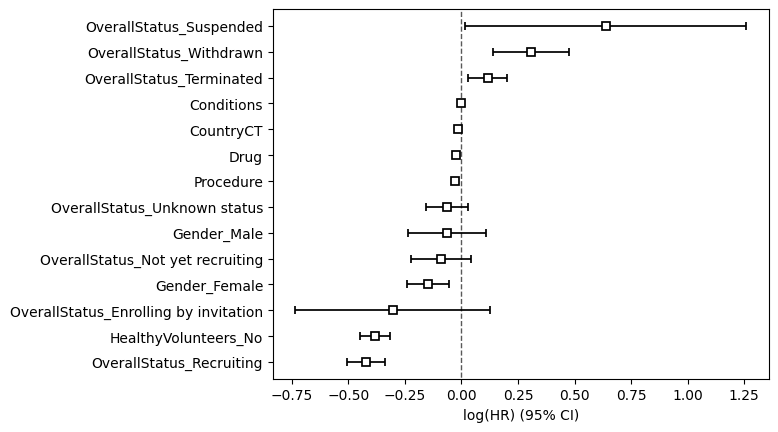

In [92]:
cph.plot()

On peut tracer les intervalles de confiances des paramètres estimés (si l'intervalle contient 0, le paramètre n'est pas significatif au seuil de 5%). Le fait de ne recruter que des femmes a un impact significatif (au seuil de 5%) et négatif sur la probabilité de sortie de l'essai clinique. Les essais cliniques qui ne demandent que des patients feminins ont donc (selon le modèle) une espérance de durée plus importantes.
Les essais cliniques ``Terminated``, c'est à dire qui ont été arretés mais n'ont pas été validés ont une probabilité de sortie plus élevée que les essais cliniques ``Completed`` (qui eux ont été validés).

Ces premières estimations montre bien un impact significatif de la complexité du profil recherché sur la durée d'un essai clinique pour les 2 modèles. Si de plus on a remarqué que le type de sponsor ne semblait pas avoir d'impact sur la durée d'un essai clinique, on complète notre analyse en évaluant la probabilité de succès d'un essai clinique dans le dossier ``Succès Essai Clinique``.